<a href="https://colab.research.google.com/github/Div-raj/PRODIGY_DS_02/blob/main/task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
import missingno as msno
from itertools import combinations
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
train_original = pd.read_csv('/content/train.csv')
test_original = pd.read_csv('/content/test.csv')
train = train_original
train.head()
train.shape
test_original.shape

(4277, 13)

In [3]:
print("Numerical variables:",train.select_dtypes(include =[np.number]).columns)
print("Categorical variables:",train.select_dtypes(include =[object]).columns)

Numerical variables: Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Categorical variables: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')


In [5]:
train[['Group', 'Individual']] = train['PassengerId'].str.split('_', expand=True)
train["Accompanied"]=train["Group"].apply(lambda x: "True" if (train["Group"].value_counts()[x]>1) else "False")
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', expand=True)
train["Total Expenditure"] = train["VRDeck"]+train["Spa"]+train["RoomService"]+train["FoodCourt"]+train["ShoppingMall"]
train["Standard_exp"]=train["FoodCourt"]+train["ShoppingMall"]
train["Premium_exp"]=train["VRDeck"]+train["Spa"]+train["RoomService"]
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Group,Individual,Accompanied,Deck,Number,Side,Total Expenditure,Standard_exp,Premium_exp
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0001,01,False,B,0,P,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,0002,01,False,F,0,S,736.0,34.0,702.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0003,01,True,A,0,S,10383.0,3576.0,6807.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0003,02,True,A,0,S,5176.0,1654.0,3522.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,0004,01,False,F,1,S,1091.0,221.0,870.0


<Axes: xlabel='Transported', ylabel='count'>

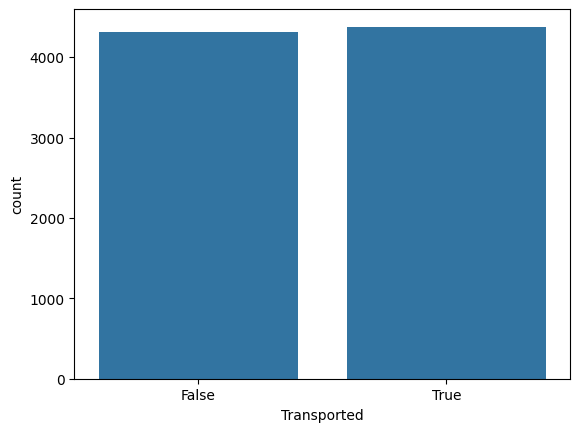

In [6]:
sns.countplot(data=train,x='Transported')

<Axes: xlabel='VIP', ylabel='count'>

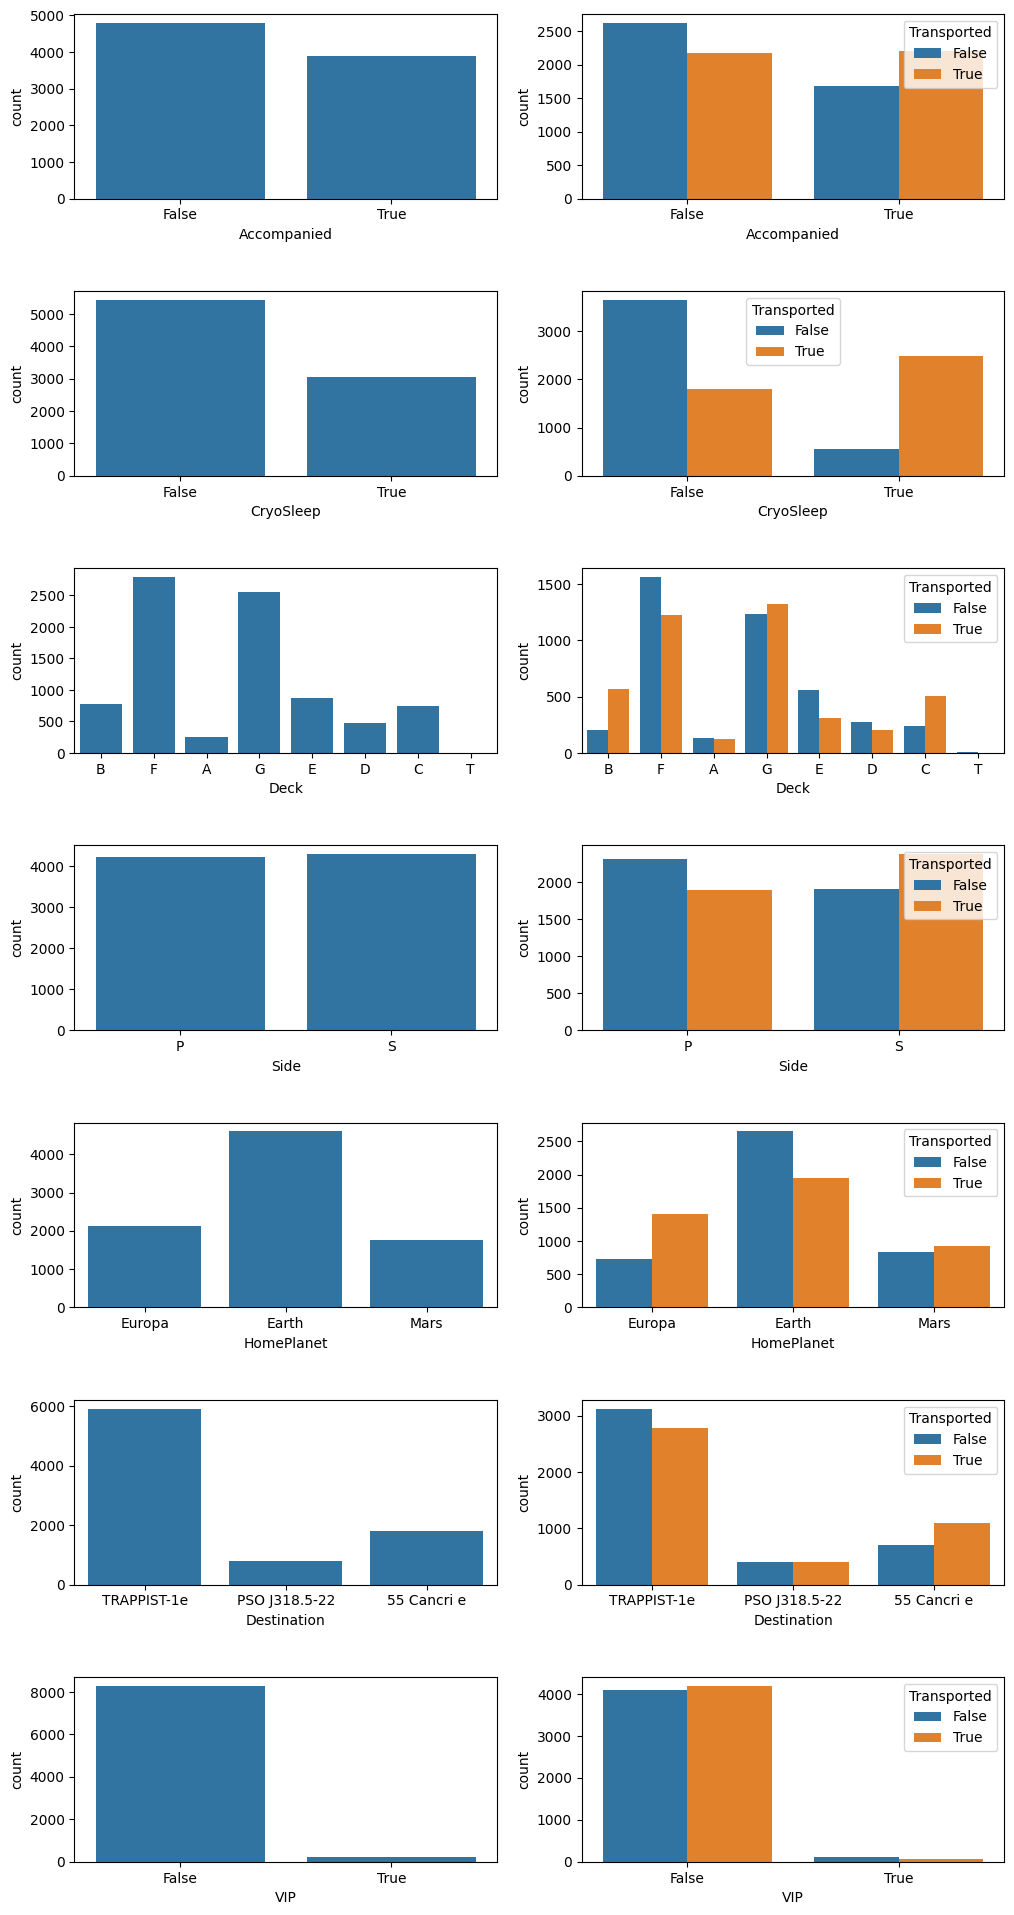

In [7]:
f,ax=plt.subplots(7,2,figsize=(12,24),gridspec_kw={'hspace': 0.5})
sns.countplot(data=train,x='Accompanied',ax=ax[0,0])
sns.countplot(data=train, x='Accompanied',hue='Transported',ax=ax[0,1])
sns.countplot(data=train,x='CryoSleep',ax=ax[1,0])
sns.countplot(data=train, x='CryoSleep',hue='Transported',ax=ax[1,1])
sns.countplot(data=train,x='Deck',ax=ax[2,0])
sns.countplot(data=train, x='Deck',hue='Transported',ax=ax[2,1])
sns.countplot(data=train,x='Side',ax=ax[3,0])
sns.countplot(data=train, x='Side',hue='Transported',ax=ax[3,1])
sns.countplot(data=train,x='HomePlanet',ax=ax[4,0])
sns.countplot(data=train, x='HomePlanet',hue='Transported',ax=ax[4,1])
sns.countplot(data=train,x='Destination',ax=ax[5,0])
sns.countplot(data=train, x='Destination',hue='Transported',ax=ax[5,1])
sns.countplot(data=train,x='VIP',ax=ax[6,0])
sns.countplot(data=train, x='VIP',hue='Transported',ax=ax[6,1])

In [8]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Expenditure,Standard_exp,Premium_exp
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,7785.000000,8304.000000,8149.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1484.601541,633.720014,839.768070
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2845.288241,1718.014113,1832.114465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,736.000000,3.000000,78.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1486.000000,621.250000,864.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,29813.000000,28600.000000


<Axes: xlabel='Age', ylabel='Density'>

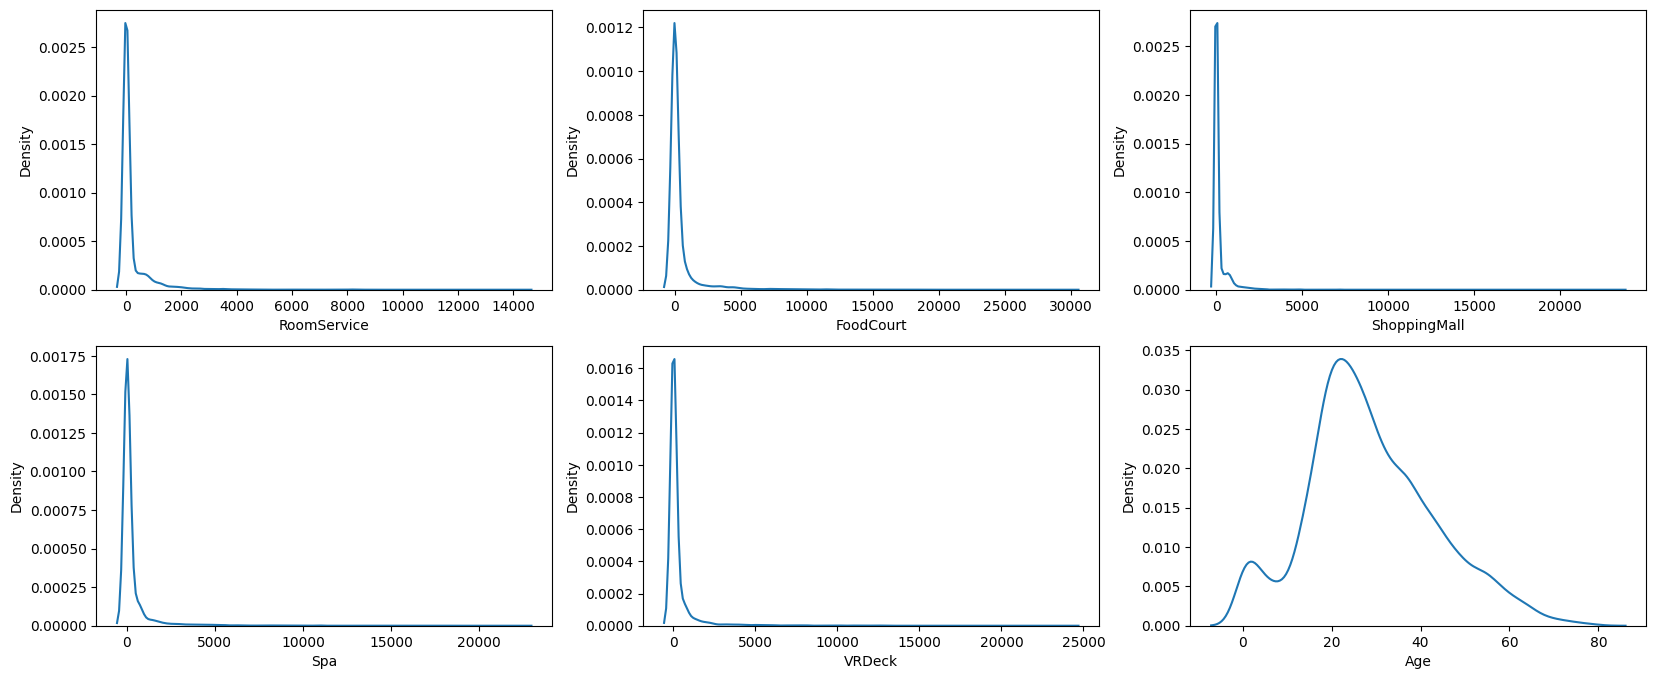

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,8))
sns.kdeplot(train['RoomService'],ax=ax[0,0])
sns.kdeplot(train['FoodCourt'],ax=ax[0,1])
sns.kdeplot(train['ShoppingMall'],ax=ax[0,2])
sns.kdeplot(train['Spa'],ax=ax[1,0])
sns.kdeplot(train['VRDeck'],ax=ax[1,1])
sns.kdeplot(train['Age'],ax=ax[1,2])

In [10]:
px.histogram(train, x="Age",color="Transported")

In [11]:
fig1=px.scatter(train, x="Age", y="RoomService",title="Scatter Plot of Age vs. Spa")
fig2=px.scatter(train, x="Age", y="FoodCourt",title="Scatter Plot of Age vs. Spa")
fig3=px.scatter(train, x="Age", y="ShoppingMall",title="Scatter Plot of Age vs. Spa")
fig4=px.scatter(train, x="Age", y="Spa",title="Scatter Plot of Age vs. Spa")
fig5=px.scatter(train, x="Age", y="VRDeck",title="Scatter Plot of Age vs. Spa")
train["Total Expenditure"] = train["VRDeck"]+train["Spa"]+train["RoomService"]+train["FoodCourt"]+train["ShoppingMall"]
fig6=px.scatter(train, x="Age", y="Total Expenditure",title="Scatter Plot of Age vs. Spa")
fig = make_subplots(rows=2, cols=3)
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)
for trace in fig4.data:
    fig.add_trace(trace, row=2, col=1)
for trace in fig5.data:
    fig.add_trace(trace, row=2, col=2)
for trace in fig6.data:
    fig.add_trace(trace, row=2, col=3)

fig.update_layout(title_text="Age vs Expenses")
fig.update_xaxes(title_text="Age", row=1, col=1)
fig.update_xaxes(title_text="Age", row=1, col=2)
fig.update_xaxes(title_text="Age", row=1, col=3)
fig.update_xaxes(title_text="Age", row=2, col=1)
fig.update_xaxes(title_text="Age", row=2, col=2)
fig.update_xaxes(title_text="Age", row=2, col=3)
fig.update_yaxes(title_text="RoomService", row=1, col=1)
fig.update_yaxes(title_text="FoodCourt", row=1, col=2)
fig.update_yaxes(title_text="ShoppingMall", row=1, col=3)
fig.update_yaxes(title_text="Spa", row=2, col=1)
fig.update_yaxes(title_text="VRDeck", row=2, col=2)
fig.update_yaxes(title_text="Total Expenditure", row=2, col=3)

In [12]:
fig = px.box(train,x='Transported',y='Total Expenditure', color='Transported')
fig.update_traces(boxmean=True)
fig.show()

fig = px.box(train,x='Deck',y='Total Expenditure', color='Deck')
fig.update_traces(boxmean=True)
fig.show()

fig1 = px.box(train, x="HomePlanet", y="Total Expenditure",color="HomePlanet", title="Box Plot of Total Expenditure by HomePlanet")
fig2 = px.box(train, x="VIP", y="Total Expenditure",color="VIP", title="Box Plot of Total Expenditure by VIP")
fig3 = px.box(train, x="Accompanied", y="Total Expenditure",color="Accompanied", title="Box Plot of Total Expenditure by Accompanied")
fig4 = px.box(train, x="CryoSleep", y="Total Expenditure", color="CryoSleep",title="Box Plot of Total Expenditure by CryoSleep")

for fig in [fig1, fig2, fig3, fig4]:
    fig.update_traces(boxmean=True)

fig = make_subplots(rows=2, cols=2, subplot_titles=("HomePlanet", "VIP", "Accompanied", "CryoSleep"), row_heights=[0.5, 0.5])

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
for trace in fig3.data:
    fig.add_trace(trace, row=2, col=1)
for trace in fig4.data:
    fig.add_trace(trace, row=2, col=2)

fig.update_layout(height=800)
fig.show()


In [14]:
train.to_csv("train_processed")
train.isna().sum()
nan_counts = train.isna().sum(axis=1)
nan_counts.max()
nan_counts.max()

8

In [15]:
unique_counts = train.groupby("Group")["HomePlanet"].nunique()
(unique_counts > 1).any()
px.scatter(train, x="Age", y="Total Expenditure", color = "CryoSleep",title="Scatter Plot of Age vs. Total Expenditure")